In [1]:
import numpy as np
import pandas as pd

In [ ]:
import sys
sys.path.insert(0, "..")   
from src.utils import (
generate_cyclical_features, 
generate_sales_features, 
add_y_targets_from_shift,
prepare_training_data_from_raw_df,
build_feature_and_label_cols,
)
from src.plot_util import plot_sales_histogram

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }
df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)
cols = ['date', 'store_item', 'store_nbr', 'item_nbr'] + [c for c in df.columns 
                                  if c not in ('date', 'store_item', 'store_nbr', 'item_nbr')]
df = df[cols]
df.rename(columns={"store_nbr": "store", "item_nbr": "item"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)



/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_72379/2905051343.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)


,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [33]:
df.head(5)

,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [34]:
df.dtypes

date           datetime64[ns]
store_item             object
store                   uint8
item                   uint32
unit_sales            float32
onpromotion            object
dtype: object

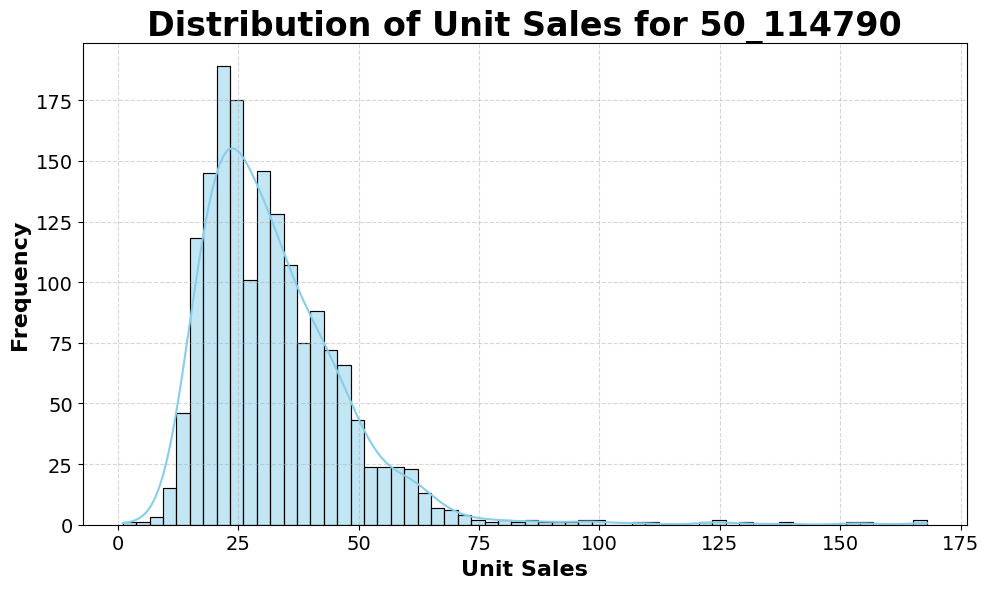

In [19]:
sid = "50_114790"
plot_sales_histogram(df, sid=sid, bins=60, log_scale=False,fn=f"../output/figures/sales_hist_{sid}.tiff")

In [20]:
# df.to_excel("../output/data/train_top_10_store_10_item.xlsx",
#             index=False)

In [24]:
cluster_df = pd.read_excel("../output/data/2025_06_07_store_item_clusters.xlsx")
cluster_df = cluster_df.drop("Unnamed: 0", axis=1)
cluster_df

,store_item,clusterId
0,3_1047679,3
1,3_114790,9
2,3_305229,17
3,3_314384,1
4,3_364606,1
...,...,...
95,8_502331,7
96,8_567623,6
97,8_581078,6
98,8_582864,4


In [26]:
cluster_df.dtypes

store_item    object
clusterId      int64
dtype: object

In [30]:
# --- make sure the key looks exactly the same in both frames -------------
df["store_item"]        = df["store_item"].astype(str)
cluster_df["store_item"] = cluster_df["store_item"].astype(str)
# --- now the merge works --------------------------------------------------
df = df.merge(
    cluster_df[["store_item", "clusterId"]],  # keep only the needed cols
    on="store_item",
    how="left",
    validate="many_to_one"                    # each item belongs to one cluster
)


In [31]:
# rows whose clusterId could not be looked‑up
no_cluster_df = df[df["clusterId"].isna()]

# just the unique keys, if that’s all you need
missing_store_items = no_cluster_df["store_item"].unique()

print(f"{len(missing_store_items)} store_items are not in the clustering table")


0 store_items are not in the clustering table


In [ ]:
generate_store_item_clusters(df, cluster_algo=KMeans(random_state=0, n_init="auto"))

In [36]:
sales_df = generate_sales_features(df.query("store_item == '3_114790'"), cluster_map=cluster_df, window_size=16)
#sales_df = generate_sales_features(df.query("store_item == '3_114790' and date <= '2017-08-15'"), window_size=16)
sales_df.head()

,start_date,store_item,store,item,cluster_id,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,...,cluster_med_day_7,cluster_med_day_8,cluster_med_day_9,cluster_med_day_10,cluster_med_day_11,cluster_med_day_12,cluster_med_day_13,cluster_med_day_14,cluster_med_day_15,cluster_med_day_16
0,2013-01-09,3_114790,3,114790,9,13.0,16.0,15.0,20.0,28.0,...,14.0,22.0,19.0,23.0,27.0,35.0,21.0,14.0,17.0,14.0
1,2013-01-25,3_114790,3,114790,9,17.0,18.0,37.0,13.0,16.0,...,18.0,18.0,33.0,36.0,31.0,18.0,25.0,17.0,20.0,23.0
2,2013-02-10,3_114790,3,114790,9,15.0,15.0,17.0,10.0,17.0,...,30.0,26.0,22.0,28.0,29.0,19.0,18.0,28.0,19.0,11.0
3,2013-02-26,3_114790,3,114790,9,16.0,16.0,14.0,22.0,41.0,...,24.0,18.0,24.0,17.0,19.0,38.0,35.0,23.0,20.0,20.0
4,2013-03-14,3_114790,3,114790,9,11.0,29.0,33.0,63.0,16.0,...,36.0,17.0,21.0,27.0,33.0,21.0,18.0,26.0,21.0,20.0


In [10]:
sales_df.columns.to_list()

['start_date',
 'store_item',
 'store',
 'item',
 'sales_day_1',
 'sales_day_2',
 'sales_day_3',
 'sales_day_4',
 'sales_day_5',
 'sales_day_6',
 'sales_day_7',
 'sales_day_8',
 'sales_day_9',
 'sales_day_10',
 'sales_day_11',
 'sales_day_12',
 'sales_day_13',
 'sales_day_14',
 'sales_day_15',
 'sales_day_16',
 'store_med_day_1',
 'store_med_day_2',
 'store_med_day_3',
 'store_med_day_4',
 'store_med_day_5',
 'store_med_day_6',
 'store_med_day_7',
 'store_med_day_8',
 'store_med_day_9',
 'store_med_day_10',
 'store_med_day_11',
 'store_med_day_12',
 'store_med_day_13',
 'store_med_day_14',
 'store_med_day_15',
 'store_med_day_16',
 'item_med_day_1',
 'item_med_day_2',
 'item_med_day_3',
 'item_med_day_4',
 'item_med_day_5',
 'item_med_day_6',
 'item_med_day_7',
 'item_med_day_8',
 'item_med_day_9',
 'item_med_day_10',
 'item_med_day_11',
 'item_med_day_12',
 'item_med_day_13',
 'item_med_day_14',
 'item_med_day_15',
 'item_med_day_16']

In [11]:
sales_df.shape

(105, 52)

In [12]:
sales_df.to_excel("../output/data/20250606_train_3_114790_sales_16_days.xlsx",
            index=False)

In [13]:
cyc_df = generate_cyclical_features(df.query("store_item == '3_114790'"), window_size=16)
cyc_df.head()

,start_date,store_item,store,item,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,...,paycycle_sin_15,paycycle_cos_15,dayofweek_sin_16,dayofweek_cos_16,weekofmonth_sin_16,weekofmonth_cos_16,monthofyear_sin_16,monthofyear_cos_16,paycycle_sin_16,paycycle_cos_16
0,2013-01-09,3_114790,3,114790,0.974928,-0.222521,0.587785,-0.809017,0.500000,8.660254e-01,...,1.224647e-16,-1.000000,0.433884,-0.900969,-9.510565e-01,0.309017,0.500000,8.660254e-01,-0.382683,-0.923880
1,2013-01-25,3_114790,3,114790,-0.433884,-0.900969,-0.951057,0.309017,0.500000,8.660254e-01,...,-2.079117e-01,-0.978148,-0.974928,-0.222521,5.877853e-01,-0.809017,0.866025,5.000000e-01,-0.587785,-0.809017
2,2013-02-10,3_114790,3,114790,-0.781831,0.623490,0.587785,-0.809017,0.866025,5.000000e-01,...,-9.350162e-01,-0.354605,0.000000,1.000000,-9.510565e-01,0.309017,0.866025,5.000000e-01,-0.992709,0.120537
3,2013-02-26,3_114790,3,114790,0.781831,0.623490,-0.951057,0.309017,0.866025,5.000000e-01,...,-9.510565e-01,0.309017,0.974928,-0.222521,5.877853e-01,-0.809017,1.000000,6.123234e-17,-0.743145,0.669131
4,2013-03-14,3_114790,3,114790,0.433884,-0.900969,0.587785,-0.809017,1.000000,6.123234e-17,...,-9.238795e-01,0.382683,-0.433884,-0.900969,-2.449294e-16,1.000000,1.000000,6.123234e-17,-0.707107,0.707107


In [14]:
cyc_df.columns.to_list()

['start_date',
 'store_item',
 'store',
 'item',
 'dayofweek_sin_1',
 'dayofweek_cos_1',
 'weekofmonth_sin_1',
 'weekofmonth_cos_1',
 'monthofyear_sin_1',
 'monthofyear_cos_1',
 'paycycle_sin_1',
 'paycycle_cos_1',
 'dayofweek_sin_2',
 'dayofweek_cos_2',
 'weekofmonth_sin_2',
 'weekofmonth_cos_2',
 'monthofyear_sin_2',
 'monthofyear_cos_2',
 'paycycle_sin_2',
 'paycycle_cos_2',
 'dayofweek_sin_3',
 'dayofweek_cos_3',
 'weekofmonth_sin_3',
 'weekofmonth_cos_3',
 'monthofyear_sin_3',
 'monthofyear_cos_3',
 'paycycle_sin_3',
 'paycycle_cos_3',
 'dayofweek_sin_4',
 'dayofweek_cos_4',
 'weekofmonth_sin_4',
 'weekofmonth_cos_4',
 'monthofyear_sin_4',
 'monthofyear_cos_4',
 'paycycle_sin_4',
 'paycycle_cos_4',
 'dayofweek_sin_5',
 'dayofweek_cos_5',
 'weekofmonth_sin_5',
 'weekofmonth_cos_5',
 'monthofyear_sin_5',
 'monthofyear_cos_5',
 'paycycle_sin_5',
 'paycycle_cos_5',
 'dayofweek_sin_6',
 'dayofweek_cos_6',
 'weekofmonth_sin_6',
 'weekofmonth_cos_6',
 'monthofyear_sin_6',
 'monthofyear_c

In [15]:
cyc_df.shape

(105, 132)

In [16]:
# Define the keys used for merging
merge_keys = ["start_date", "store_item", "store", "item"]

# Identify missing rows from non_overlap_df2 that are not in non_overlap_df
missing_from_df = sales_df.merge(
    cyc_df[merge_keys],
    on=merge_keys,
    how="left",
    indicator=True
).query('_merge == "left_only"')

# Optional: drop the merge indicator column
missing_from_df = missing_from_df.drop(columns="_merge")

# Show how many are missing
print(f"Missing rows in non_overlap_df: {missing_from_df.shape[0]}")


Missing rows in non_overlap_df: 0


In [17]:
cyc_df.to_excel("../output/data/20250606_train_3_114790_cyclical_features_16_days.xlsx",
            index=False)

In [18]:
merged_df = pd.merge(sales_df, cyc_df, on=["store_item", "start_date", "store", "item" ])
merged_df.head()

,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,paycycle_sin_15,paycycle_cos_15,dayofweek_sin_16,dayofweek_cos_16,weekofmonth_sin_16,weekofmonth_cos_16,monthofyear_sin_16,monthofyear_cos_16,paycycle_sin_16,paycycle_cos_16
0,2013-01-09,3_114790,3,114790,13.0,16.0,15.0,20.0,28.0,16.0,...,1.224647e-16,-1.000000,0.433884,-0.900969,-9.510565e-01,0.309017,0.500000,8.660254e-01,-0.382683,-0.923880
1,2013-01-25,3_114790,3,114790,17.0,18.0,37.0,13.0,16.0,20.0,...,-2.079117e-01,-0.978148,-0.974928,-0.222521,5.877853e-01,-0.809017,0.866025,5.000000e-01,-0.587785,-0.809017
2,2013-02-10,3_114790,3,114790,15.0,15.0,17.0,10.0,17.0,20.0,...,-9.350162e-01,-0.354605,0.000000,1.000000,-9.510565e-01,0.309017,0.866025,5.000000e-01,-0.992709,0.120537
3,2013-02-26,3_114790,3,114790,16.0,16.0,14.0,22.0,41.0,36.0,...,-9.510565e-01,0.309017,0.974928,-0.222521,5.877853e-01,-0.809017,1.000000,6.123234e-17,-0.743145,0.669131
4,2013-03-14,3_114790,3,114790,11.0,29.0,33.0,63.0,16.0,18.0,...,-9.238795e-01,0.382683,-0.433884,-0.900969,-2.449294e-16,1.000000,1.000000,6.123234e-17,-0.707107,0.707107


In [19]:
merged_df.shape


(105, 180)

In [20]:
merged_df.to_excel("../output/data/20250606_train_3_114790_sales_cyclical_features_16_days.xlsx",
            index=False)

In [22]:
final_df = add_y_targets_from_shift(merged_df, window_size=16)
y_cols = [col for col in final_df.columns if col.startswith("y_")]
final_df = final_df.dropna(subset=y_cols)
final_df.to_excel("../output/data/20250606_train_3_114790_sales_cyclical_features_16_days_X_y.xlsx",
            index=False)


In [22]:
final_df.shape

(104, 292)

### Full Window Stacking

In [5]:
final_df = prepare_training_data_from_raw_df(df, window_size=16)

cyc_df.shape: (165804, 164)
sales_df.shape: (10500, 52)
merged_df.shape: (10493, 212)
merged_df.shape: (10386, 420)


In [6]:
final_df.head(5)

,start_date,store_item,store,item,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,...,y_item_med_day_7,y_item_med_day_8,y_item_med_day_9,y_item_med_day_10,y_item_med_day_11,y_item_med_day_12,y_item_med_day_13,y_item_med_day_14,y_item_med_day_15,y_item_med_day_16
0,2013-01-09,3_1047679,3,1047679,0.974928,-0.222521,0.587785,-0.809017,0.500000,8.660254e-01,...,62.5,89.5,148.0,142.5,102.0,76.0,79.0,70.0,79.5,95.0
1,2013-01-25,3_1047679,3,1047679,-0.433884,-0.900969,-0.951057,0.309017,0.500000,8.660254e-01,...,74.5,84.5,93.0,65.5,70.0,41.0,69.0,76.0,151.0,57.0
2,2013-02-10,3_1047679,3,1047679,-0.781831,0.623490,0.587785,-0.809017,0.866025,5.000000e-01,...,55.5,63.0,84.0,53.5,114.5,118.0,156.0,50.0,54.0,132.0
3,2013-02-26,3_1047679,3,1047679,0.781831,0.623490,-0.951057,0.309017,0.866025,5.000000e-01,...,80.5,51.0,68.5,135.5,157.0,89.0,30.0,62.0,86.0,107.0
4,2013-03-14,3_1047679,3,1047679,0.433884,-0.900969,0.587785,-0.809017,1.000000,6.123234e-17,...,120.5,188.0,204.0,103.0,54.0,73.5,58.5,98.5,178.0,225.5


In [7]:
final_df.shape

(10386, 420)

In [12]:
meta_cols, feature_cols, label_cols = build_feature_and_label_cols(window_size=16)
print(meta_cols)
print(feature_cols)
print(label_cols)

['start_date', 'store_item', 'store', 'item']
['sales_day_1', 'sales_day_2', 'sales_day_3', 'sales_day_4', 'sales_day_5', 'sales_day_6', 'sales_day_7', 'sales_day_8', 'sales_day_9', 'sales_day_10', 'sales_day_11', 'sales_day_12', 'sales_day_13', 'sales_day_14', 'sales_day_15', 'sales_day_16', 'store_med_day_1', 'store_med_day_2', 'store_med_day_3', 'store_med_day_4', 'store_med_day_5', 'store_med_day_6', 'store_med_day_7', 'store_med_day_8', 'store_med_day_9', 'store_med_day_10', 'store_med_day_11', 'store_med_day_12', 'store_med_day_13', 'store_med_day_14', 'store_med_day_15', 'store_med_day_16', 'item_med_day_1', 'item_med_day_2', 'item_med_day_3', 'item_med_day_4', 'item_med_day_5', 'item_med_day_6', 'item_med_day_7', 'item_med_day_8', 'item_med_day_9', 'item_med_day_10', 'item_med_day_11', 'item_med_day_12', 'item_med_day_13', 'item_med_day_14', 'item_med_day_15', 'item_med_day_16', 'dayofweek_sin_1', 'dayofweek_sin_2', 'dayofweek_sin_3', 'dayofweek_sin_4', 'dayofweek_sin_5', 'dayo

In [13]:
final_df[meta_cols + feature_cols + label_cols].to_excel("../output/data/20250607_2_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx",
            index=False)

In [8]:
final_df.to_excel("../output/data/20250607_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx",
            index=False)

In [ ]:
# # Define the keys used for merging
# merge_keys = ["start_date", "store_item", "store", "item"]

# # Identify missing rows from non_overlap_df3 that are not in non_overlap_df
# missing_from_df = non_overlap_df2.merge(
#     non_overlap_df3[merge_keys],
#     on=merge_keys,
#     how="left",
#     indicator=True
# ).query('_merge == "left_only"')

# # Optional: drop the merge indicator column
# missing_from_df = missing_from_df.drop(columns="_merge")

# # Show how many are missing
# print(f"Missing rows in non_overlap_df: {missing_from_df.shape[0]}")

Missing rows in non_overlap_df: 0


In [13]:
%pwd

'/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook'

In [ ]:
final_df = pd.read_excel("../output/data/20250530_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx")
final_df.head()

,start_date,store_item,store,item,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,...,y_item_med_day_7,y_item_med_day_8,y_item_med_day_9,y_item_med_day_10,y_item_med_day_11,y_item_med_day_12,y_item_med_day_13,y_item_med_day_14,y_item_med_day_15,y_item_med_day_16
0,2013-01-09,3_1047679,3,1047679,0.974928,-0.222521,0.587785,-0.809017,0.500000,8.660254e-01,...,62.5,89.5,148.0,142.5,102.0,76.0,79.0,70.0,79.5,95.0
1,2013-01-25,3_1047679,3,1047679,-0.433884,-0.900969,-0.951057,0.309017,0.500000,8.660254e-01,...,74.5,84.5,93.0,65.5,70.0,41.0,69.0,76.0,151.0,57.0
2,2013-02-10,3_1047679,3,1047679,-0.781831,0.623490,0.587785,-0.809017,0.866025,5.000000e-01,...,55.5,63.0,84.0,53.5,114.5,118.0,156.0,50.0,54.0,132.0
3,2013-02-26,3_1047679,3,1047679,0.781831,0.623490,-0.951057,0.309017,0.866025,5.000000e-01,...,80.5,51.0,68.5,135.5,157.0,89.0,30.0,62.0,86.0,107.0
4,2013-03-14,3_1047679,3,1047679,0.433884,-0.900969,0.587785,-0.809017,1.000000,6.123234e-17,...,120.5,188.0,204.0,103.0,54.0,73.5,58.5,98.5,178.0,225.5
